## Classical Diffusion Model ##

This architecture follows the quantum diffusion model structure, training the same number of parameters, using the same number of layers, and following the same complexity. It is used as a baseline for comparison between the classical and quantum models for the same tasks.

First, a classical model without the quantum layer but with the same shapes and encodings. There are also some versions of the model with validation and with self-attention at the end.

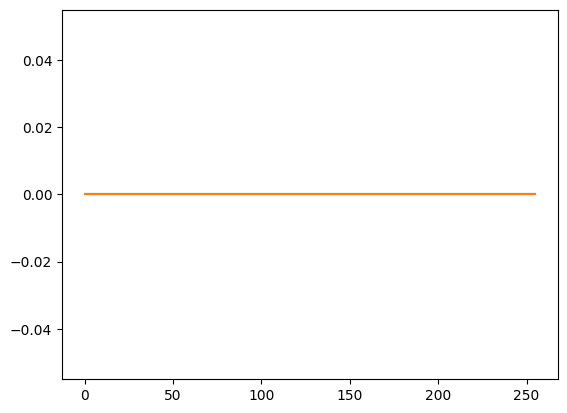

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py
import scipy.linalg

# filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG3_normalized_16_xl"
filename = "../../data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    for i in range(len(encoded_data)):
        # scrambled_state = np.random.permutation(encoded_data[i].flatten())
        gaussian_matrix = np.random.normal(0, 0.1, (16, 16))
        scrambled_state = np.multiply(gaussian_matrix, encoded_data[i])
        scrambled_vectors.append(scrambled_state)
    return np.array(scrambled_vectors).reshape(len(encoded_data), 8, 8, 4)

def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = scrambled_states.reshape(scrambled_states.shape[0], 8, 8, 4)
    return reshaped_scrambled_states

def visualize_data(original_data, encoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(encoded_data[sample_index], cmap='viridis')
    axes[1].set_title("AAA Data")
    
    plt.tight_layout()
    plt.show()

class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_samples = 1000
num_epochs = 10
loss_values = []

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)
# plt.plot(scrambled_states[0])
plt.plot(scrambled_states[4])
plt.plot(encoded_data[4])

Epoch [1/10], Loss: 0.0069
Epoch [2/10], Loss: 0.0047
Epoch [3/10], Loss: 0.0042
Epoch [4/10], Loss: 0.0040
Epoch [5/10], Loss: 0.0039
Epoch [6/10], Loss: 0.0039
Epoch [7/10], Loss: 0.0039
Epoch [8/10], Loss: 0.0039
Epoch [9/10], Loss: 0.0039
Epoch [10/10], Loss: 0.0038


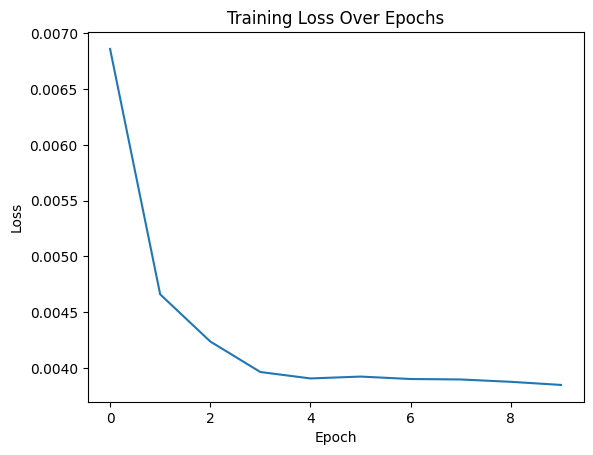

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017354958..0.032957047].


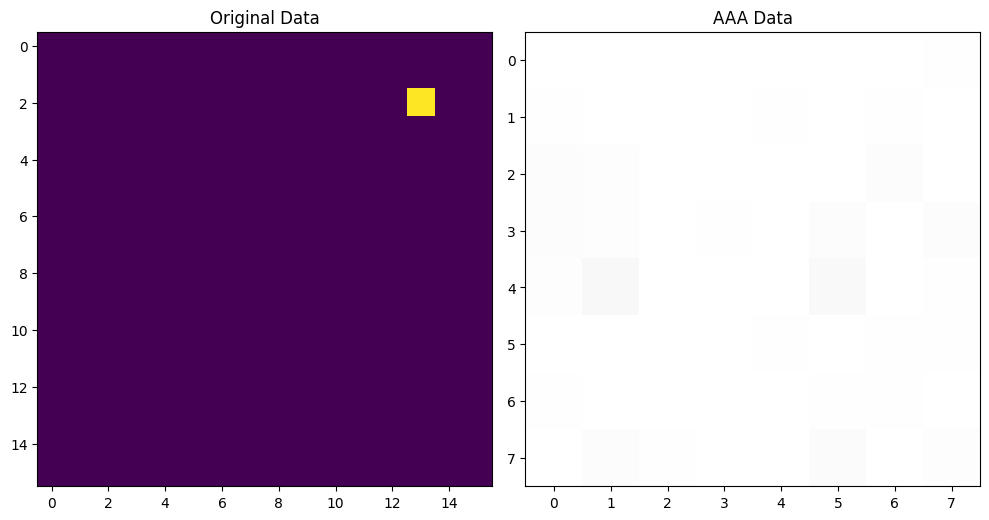

(100000, 16, 16)


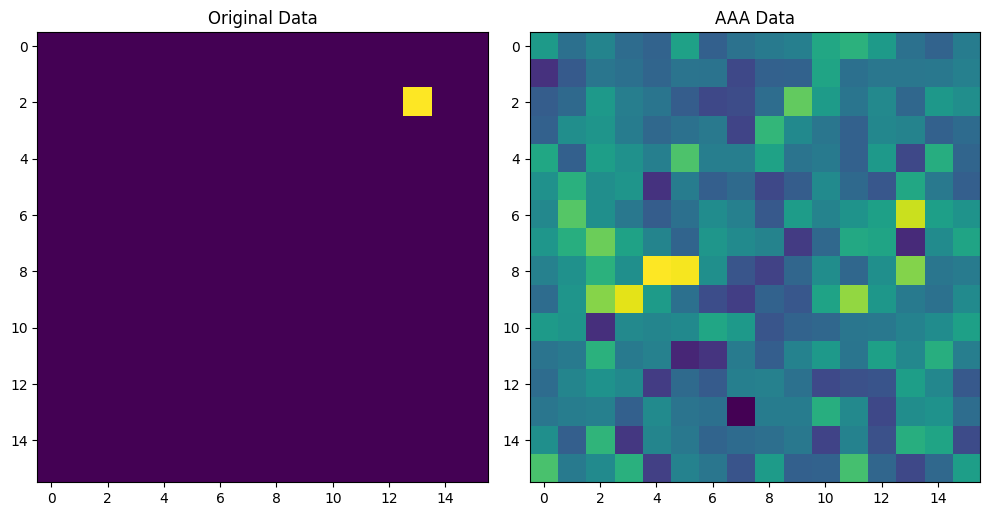

FID score: 0.9773125191354597


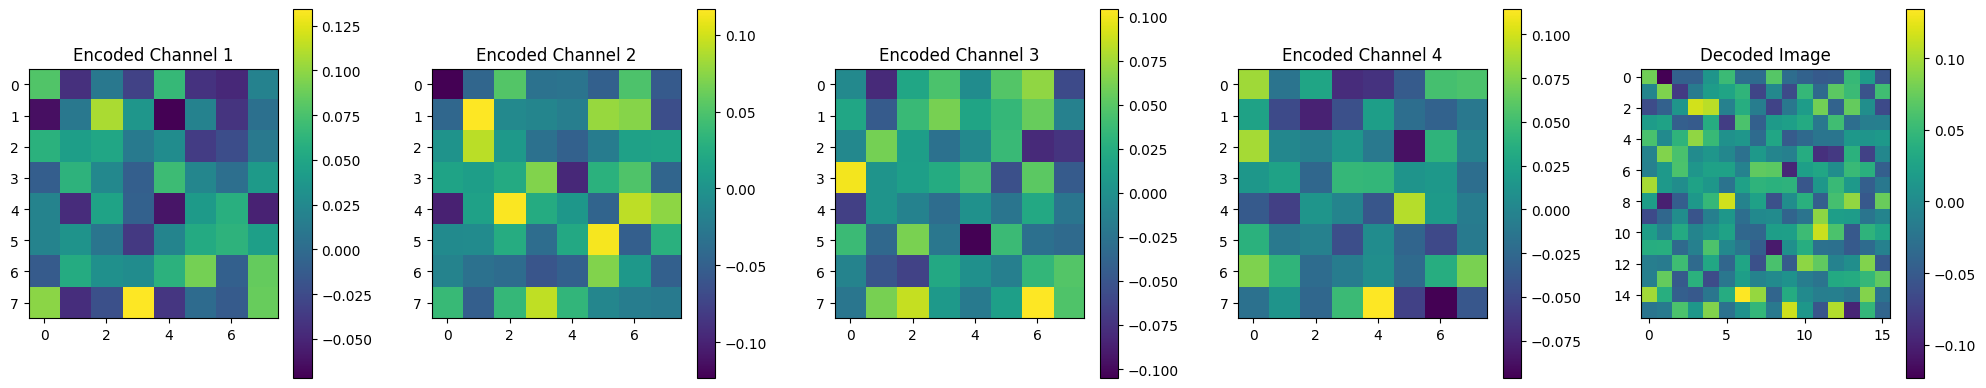

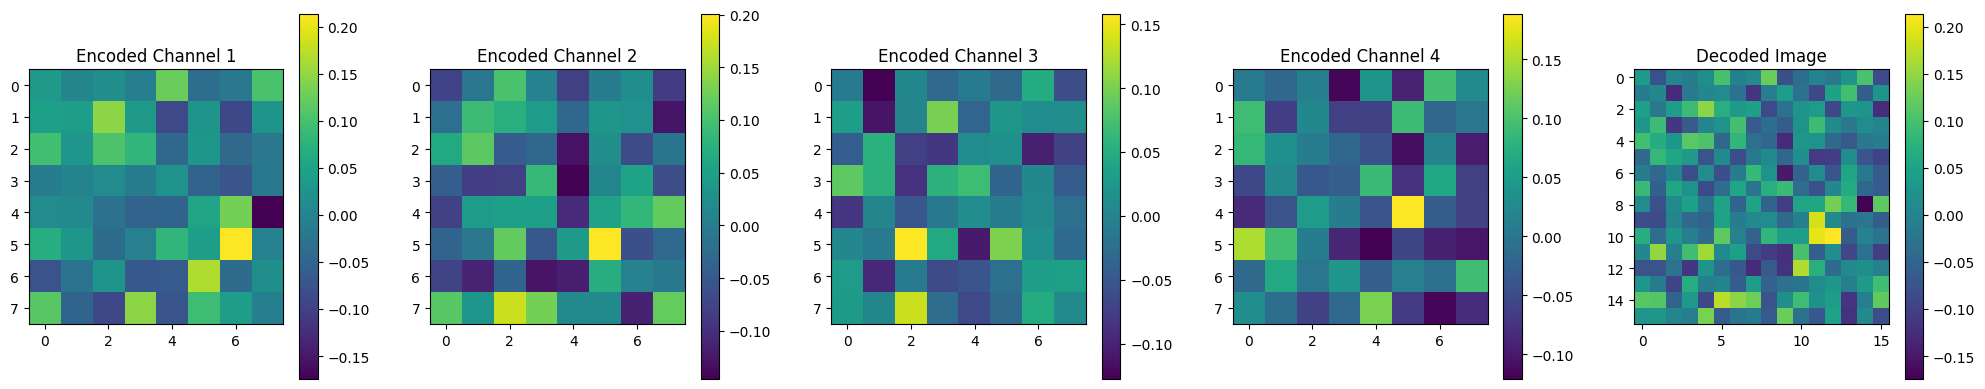

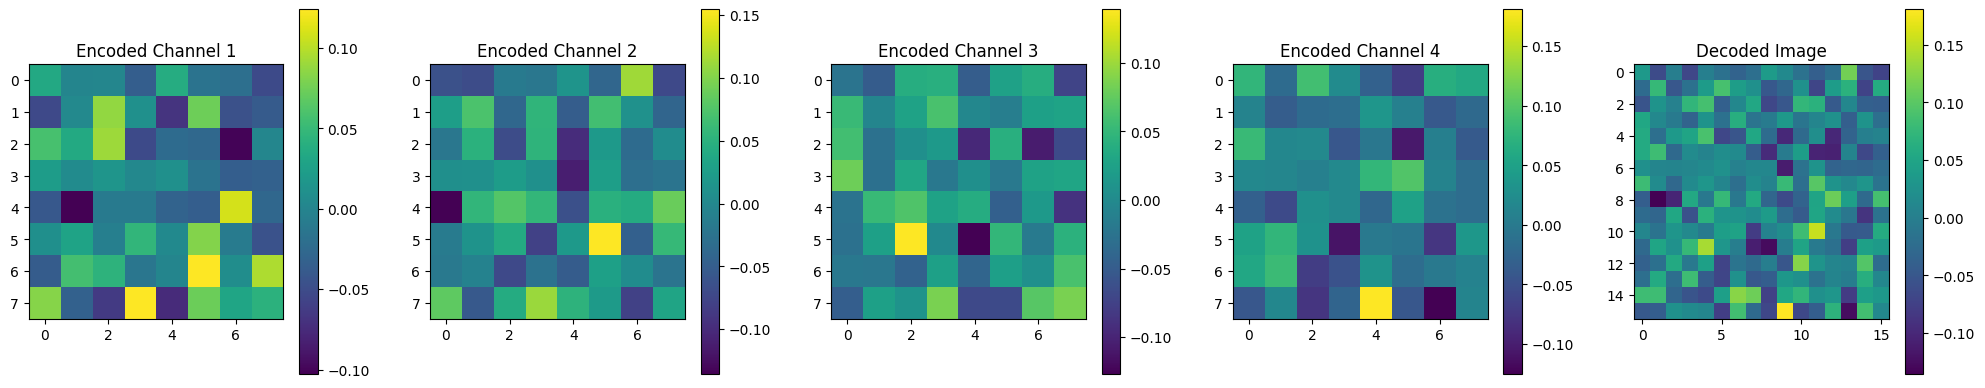

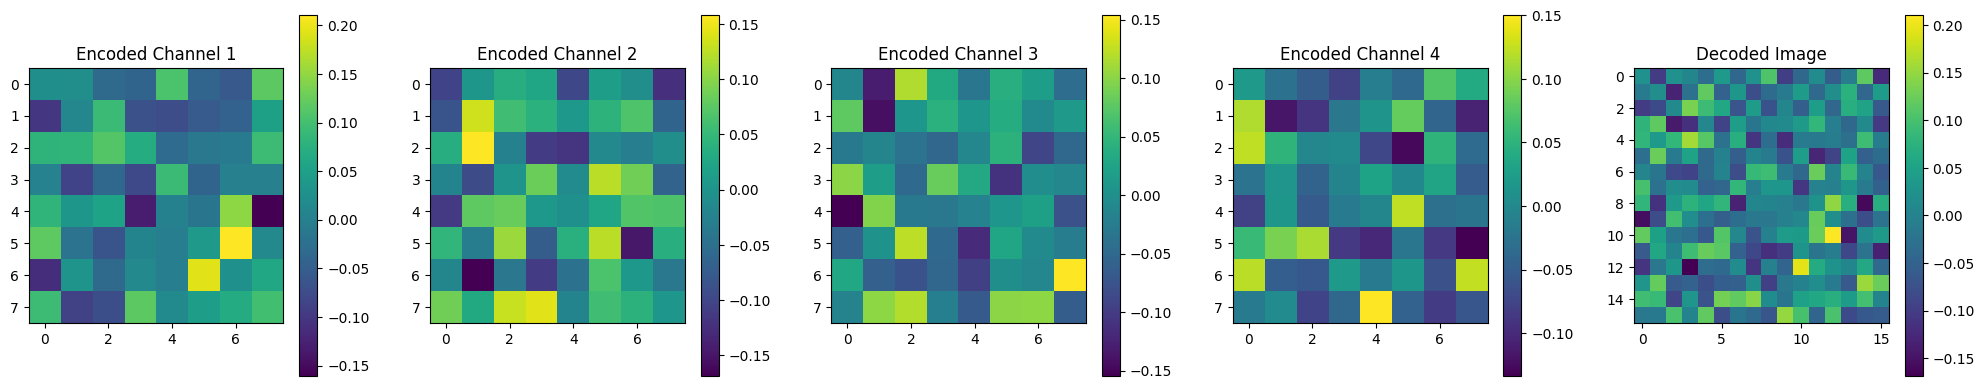

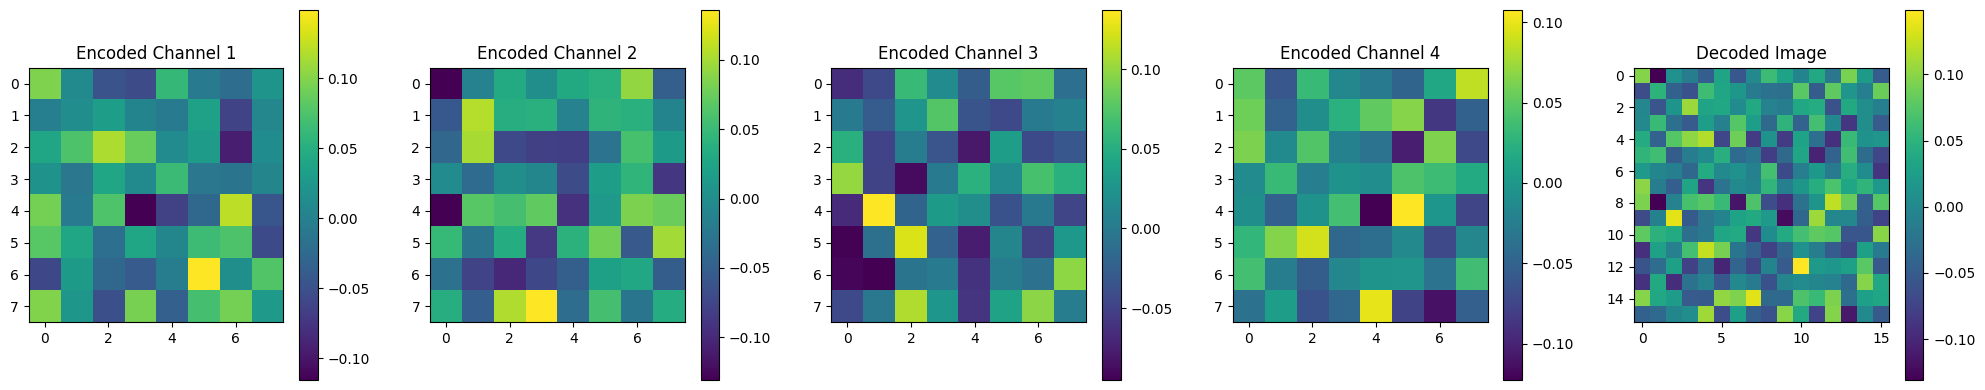

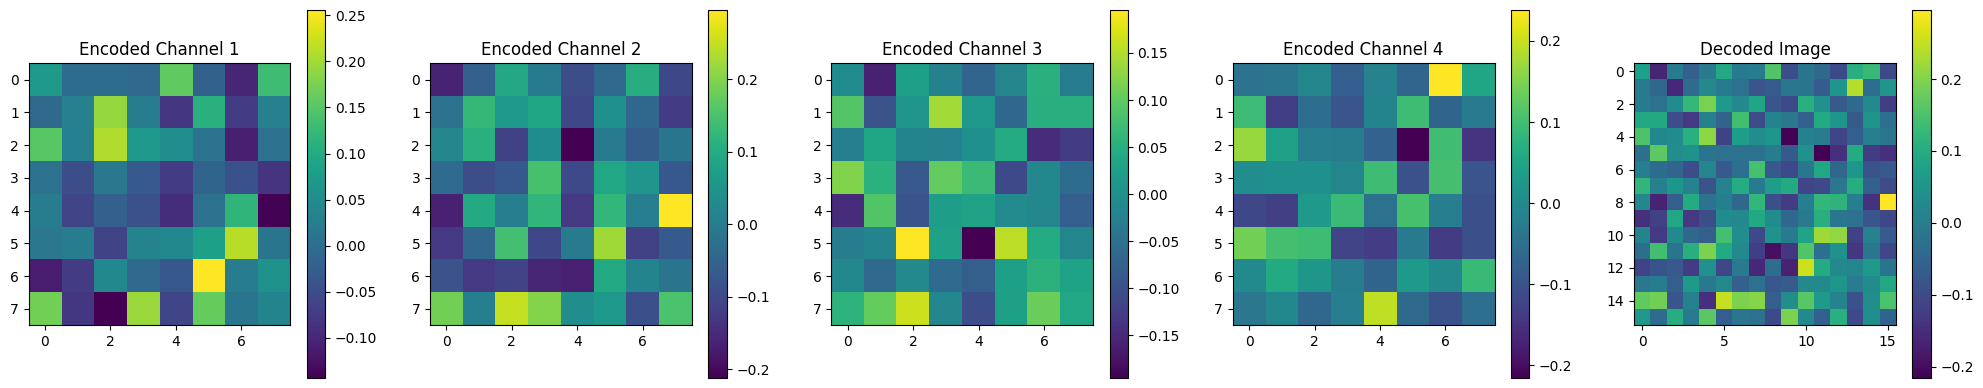

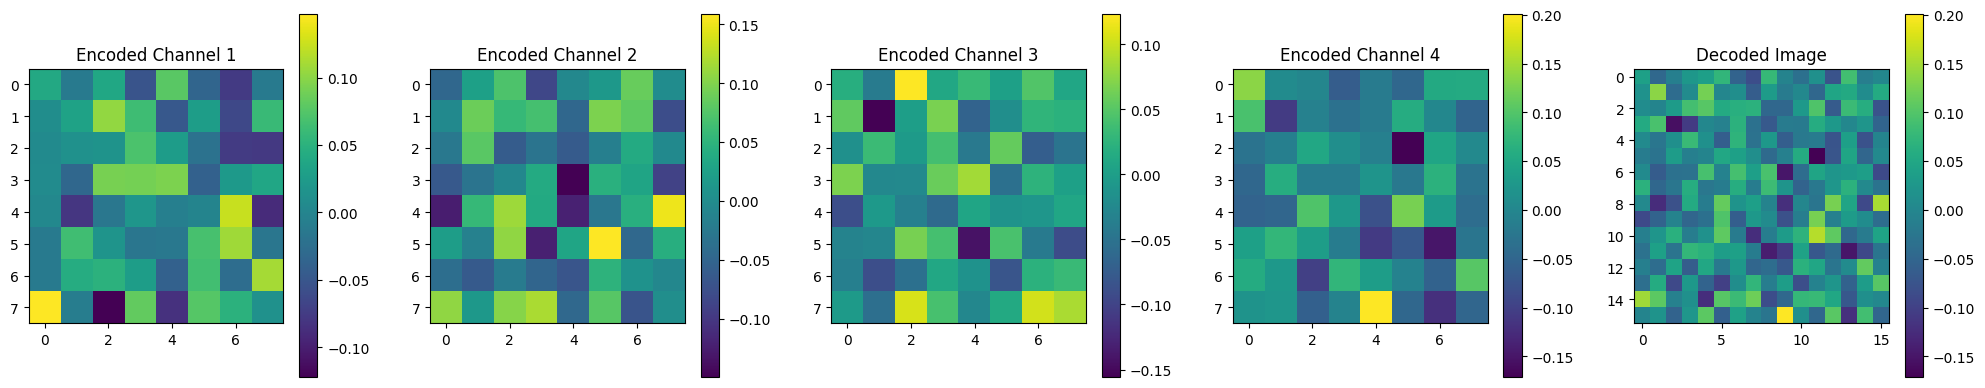

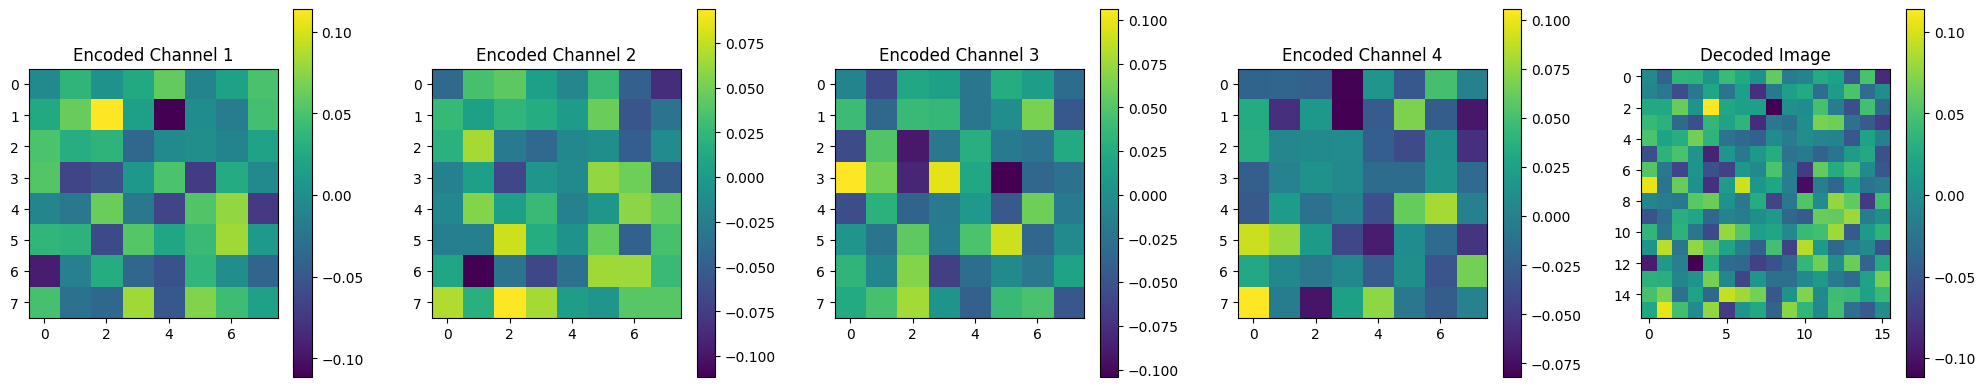

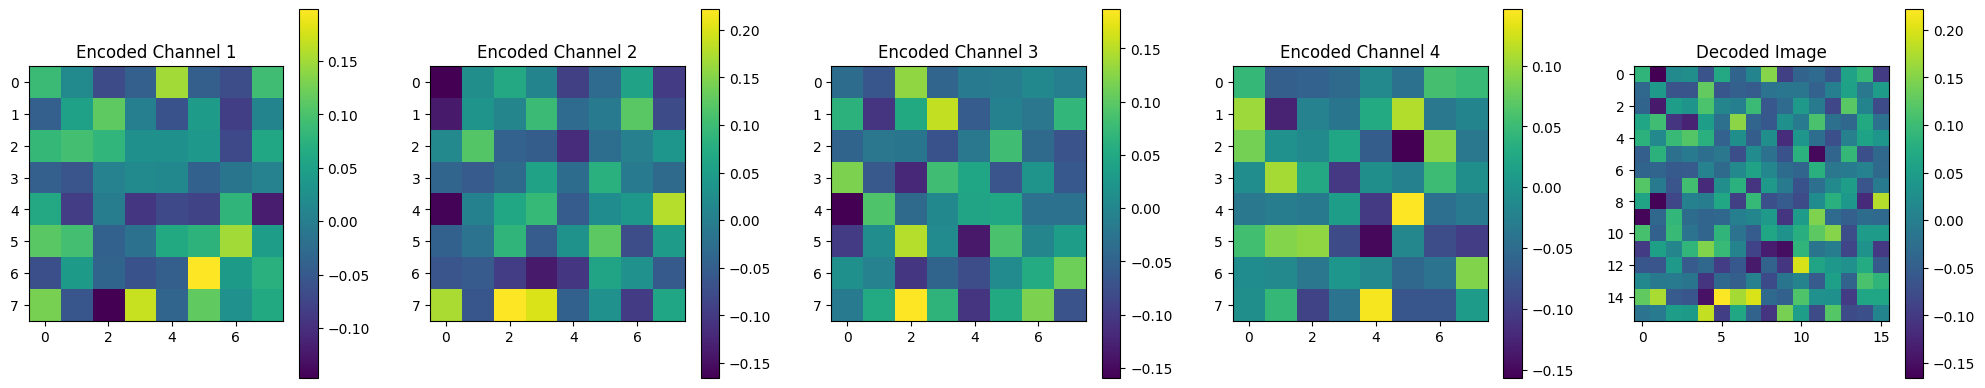

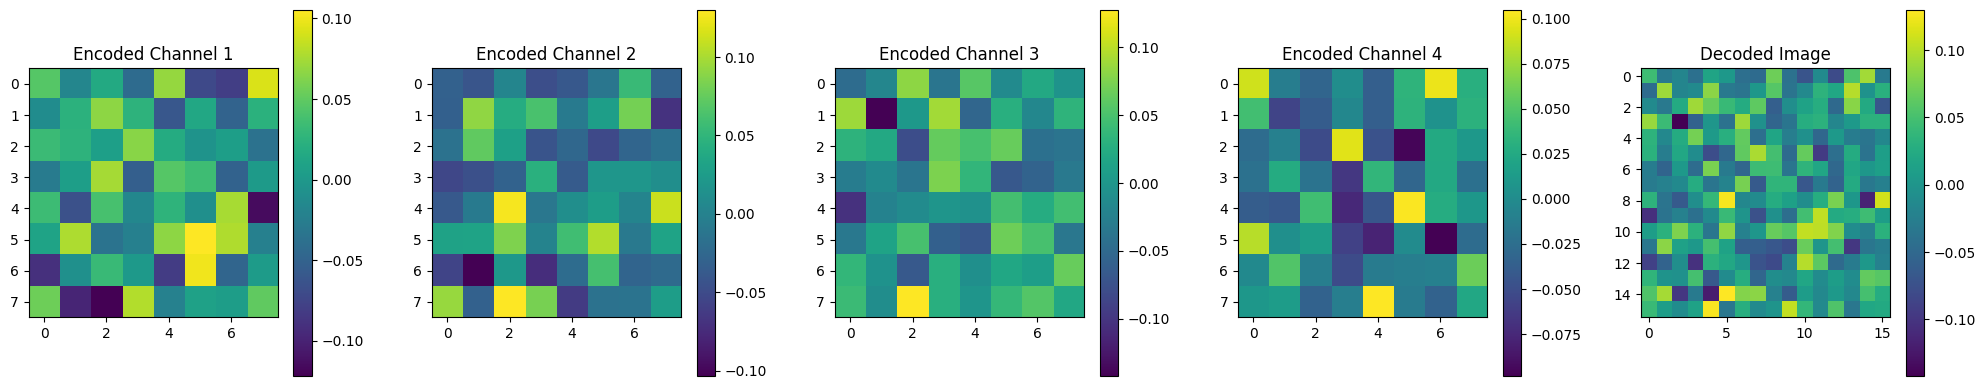

In [6]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states)
    loss = criterion(outputs, encoded_data)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

denoised_states = model(scrambled_states).view(num_samples, 8, 8, 4).detach().numpy()
visualize_data(data_X, denoised_states, sample_index=0)

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

decoded_data = decode(denoised_states)
# decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_data(data_X, decoded_data, sample_index=0)

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # Flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval() 
    with torch.no_grad():
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            # print(generated_data)

            # decoded_images = flip(decode(generated_data))
            decoded_images = decode(generated_data)
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))

            # Display each channel separately
            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded Channel {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded Image")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_new_images = 10
new_images = generate_new_images(model, num_new_images)


Notes for presentation:
- Tried on 10k samples --> cleaner output with less noise thank 1k samples
- Trained on 100k samples --> not much difference except slower convergence, but could tune hyperparameters for better performance; significantly slower sample generation
- Tried permutations which basically gives the same output as gaussian noise (do permutations follow a normal distribution?)

TODO:
Reshape data and model inputs to take in 3 channel data
- This involvess scrambling each of the channels with the same random unitary/gaussian matrix and get the model to learn distributions in sets of three 
- Make 100k datasets for QG2 and QG3

Questions:
- Is there a formula defining the relationship between the three channels? Do they have something in common they wouldn't share with the other channels? How do we verify we've generated the right channels (FID mean doesn't capture thet closeness between the three)?


In [3]:
# Make minimum numbers purple and max yellow
# Make sure the FID is an average

print(data_X.shape)

(100000, 16, 16)


Training data shape: torch.Size([800, 256])
Validation data shape: torch.Size([200, 256])
UNet(
  (encoder1): Sequential(
    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (attention1): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (attention2): SelfAttention(
    (query_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


Epoch [15/50], Loss: 203.8493, Val Loss: 82.6624, FID: 20161.3415
Epoch [16/50], Loss: 82.6686, Val Loss: 5.1105, FID: 1455.4597
Epoch [17/50], Loss: 5.1126, Val Loss: 305.6374, FID: 77314.8296
Epoch [18/50], Loss: 305.7860, Val Loss: 16.8309, FID: 4491.9838
Epoch [19/50], Loss: 16.8329, Val Loss: 687.5594, FID: 174863.2727
Epoch [20/50], Loss: 687.5714, Val Loss: 6.0832, FID: 1727.7776
Epoch [21/50], Loss: 6.0854, Val Loss: 104.0009, FID: 26847.5329
Epoch [22/50], Loss: 104.0092, Val Loss: 12.1431, FID: 3308.6306
Epoch [23/50], Loss: 12.1452, Val Loss: 0.3441, FID: 317.4302
Epoch [24/50], Loss: 0.3445, Val Loss: 0.0331, FID: 258.7040
Epoch [25/50], Loss: 0.0331, Val Loss: 0.0580, FID: 265.5397
Epoch [26/50], Loss: 0.0580, Val Loss: 0.0649, FID: 268.4373
Epoch [27/50], Loss: 0.0650, Val Loss: 42.5602, FID: 11156.9891
Epoch [28/50], Loss: 42.5481, Val Loss: 0.0805, FID: 274.7468
Epoch [29/50], Loss: 0.0806, Val Loss: 0.0881, FID: 277.7887
Epoch [30/50], Loss: 0.0881, Val Loss: 0.0917, F

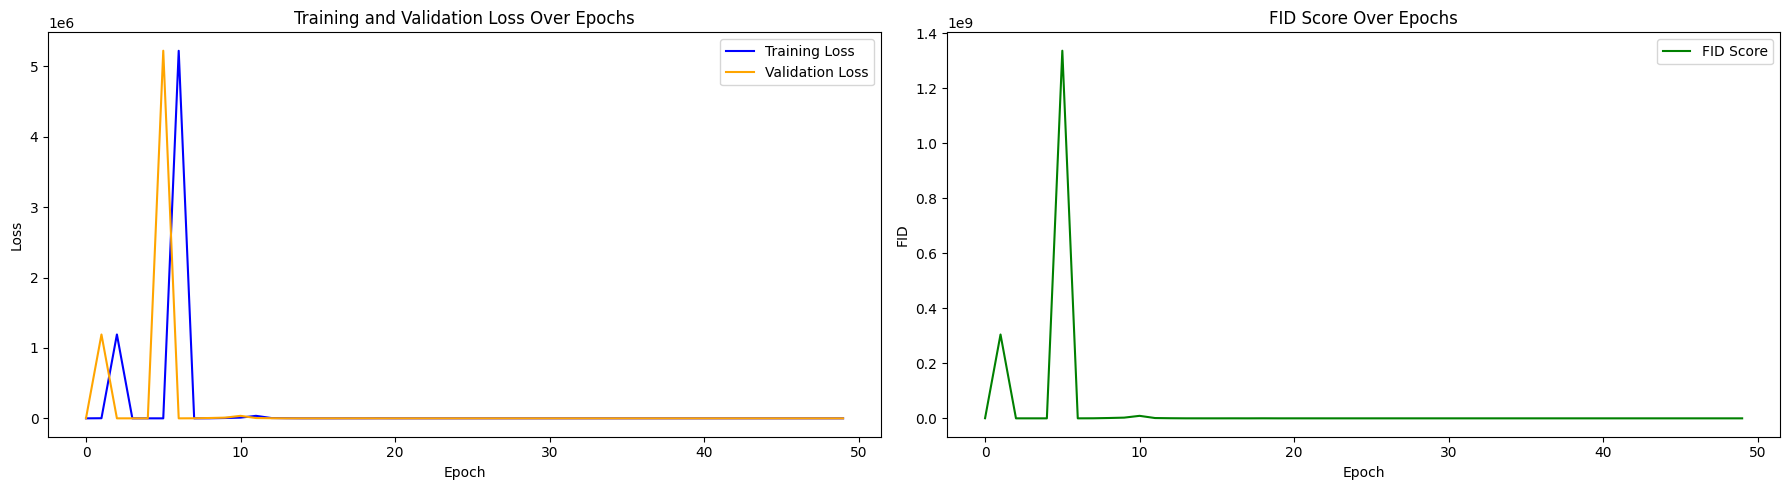

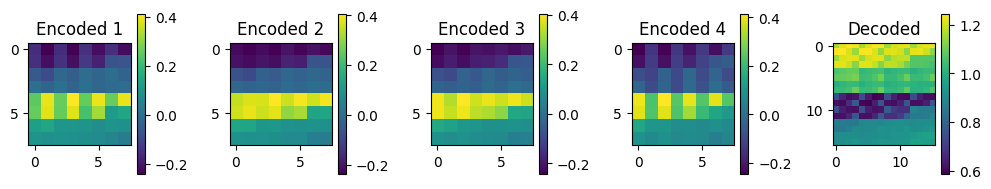

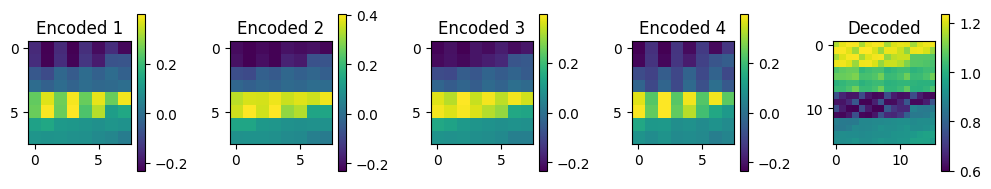

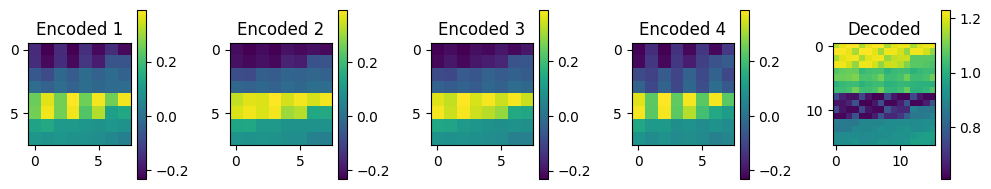

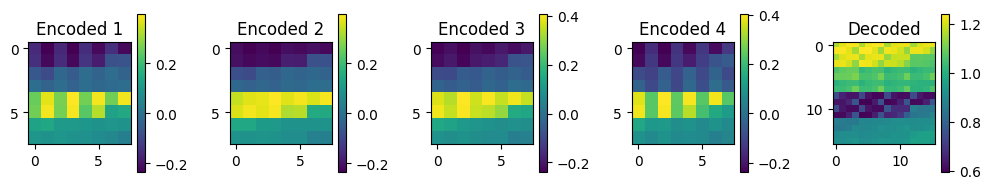

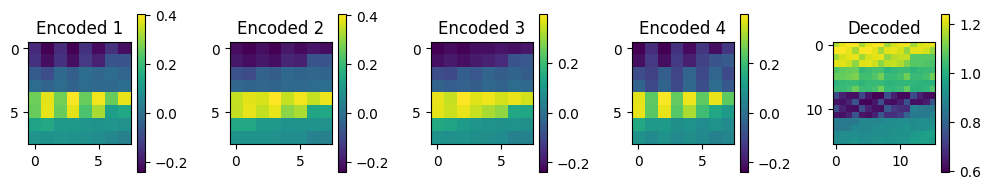

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy

# Split the dataset
train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training data shape: {train_encoded_data.shape}")
print(f"Validation data shape: {val_encoded_data.shape}")

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# U-Net with self-attention
class UNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, intermediate_dim):
        super(UNet, self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.attention1 = SelfAttention(hidden_dim)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.attention2 = SelfAttention(hidden_dim * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, intermediate_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(intermediate_dim, intermediate_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.attention3 = SelfAttention(intermediate_dim)

        self.upconv2 = nn.ConvTranspose2d(intermediate_dim, hidden_dim * 2, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.attention4 = SelfAttention(hidden_dim * 2)

        self.upconv1 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.attention5 = SelfAttention(hidden_dim)

        self.output_layer = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        a1 = self.attention1(e1)
        p1 = self.pool1(a1)

        e2 = self.encoder2(p1)
        a2 = self.attention2(e2)
        p2 = self.pool2(a2)

        b = self.bottleneck(p2)
        b = self.attention3(b)

        u2 = self.upconv2(b)
        cat2 = torch.cat([u2, a2], dim=1)
        d2 = self.decoder2(cat2)
        d2 = self.attention4(d2)

        u1 = self.upconv1(d2)
        cat1 = torch.cat([u1, a1], dim=1)
        d1 = self.decoder1(cat1)
        d1 = self.attention5(d1)

        out = self.output_layer(d1)
        return out

input_channels = 4  # 8x8x4 reshaped as 4 channels
output_channels = 4  # 8x8x4 reshaped as 4 channels

model = UNet(input_channels, hidden_dim=128, output_dim=output_channels, intermediate_dim=256)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(model)

# Utility functions
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_decoded_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

# Training loop with validation
num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), 4, 8, 8))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), 4, 8, 8))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), 4, 8, 8))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), 4, 8, 8))
        val_loss_values.append(val_loss.item())
        
        # Compute FID score
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), 4, 8, 8))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

# Plotting the results
plt.figure(figsize=(18, 5))

# Plot training and validation loss on the same plot
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

def generate_new_images(model, num_images, input_dim=4*8*8):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, 4, 8, 8)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)


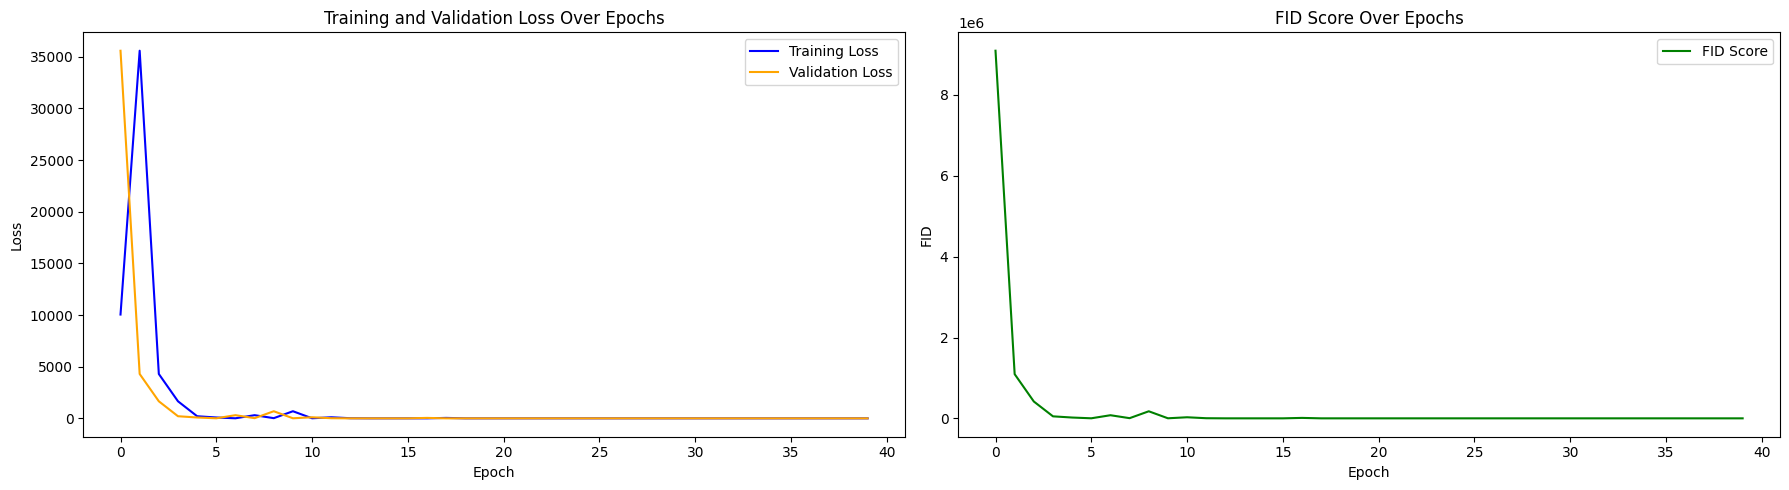

In [11]:
plt.figure(figsize=(18, 5))

# Zooming in past the jump on the plots with [10:]
plt.subplot(1, 2, 1)
plt.plot(loss_values[10:], label='Training Loss', color='blue')
plt.plot(val_loss_values[10:], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores[10:], label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()